# 팀 스마일C 코드 제출
* 팀원: 정우섭, 김유민, 김유진, 장동언, 황정묵
* PRIVATE SCORE: 0.65887 
* PRIVATE RANKING: 36

# 개발 환경
* OS : Windows11
* python: 3.10.10
* 라이브러리 버전 : requirements.txt 참조

# 0.Data Load

In [1]:
!pip install catboost
!pip install lightgbm
!pip install optuna 
!pip install xgboost
!pip install torch

In [2]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns 

# model evaluation, preprocessing 
import sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, log_loss

# sequential model modeling 
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation
from keras import backend as K 
from keras import regularizers
from keras.layers import Dense,Dropout, Activation, BatchNormalization, Conv2D, Flatten  
from keras import optimizers, metrics, callbacks
from keras.backend import clear_session

# optuna Hyper-params tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour

# ML classification models 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier

# Google Drive mount
from google.colab import drive 
drive.mount('/content/drive')

In [3]:
# seed fixing for reproduction 
import torch 
import random as rn 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정
seed_num=37

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(37)
seed_num=37
seed=37

np.random.seed(seed_num)
rn.seed(seed_num) 
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(config=session_conf)
K.set_session(sess)

class config:   
    seed = 37  
    device = "cuda:0"            

def seed_everything(seed: int = 37):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
seed_everything(config.seed)
tf.random.set_seed(37) # tensorflow global seed 
print(config.seed)     

37


In [4]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
submit = pd.read_csv('./sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

# 1.Data & Features

## 1.1 EDA

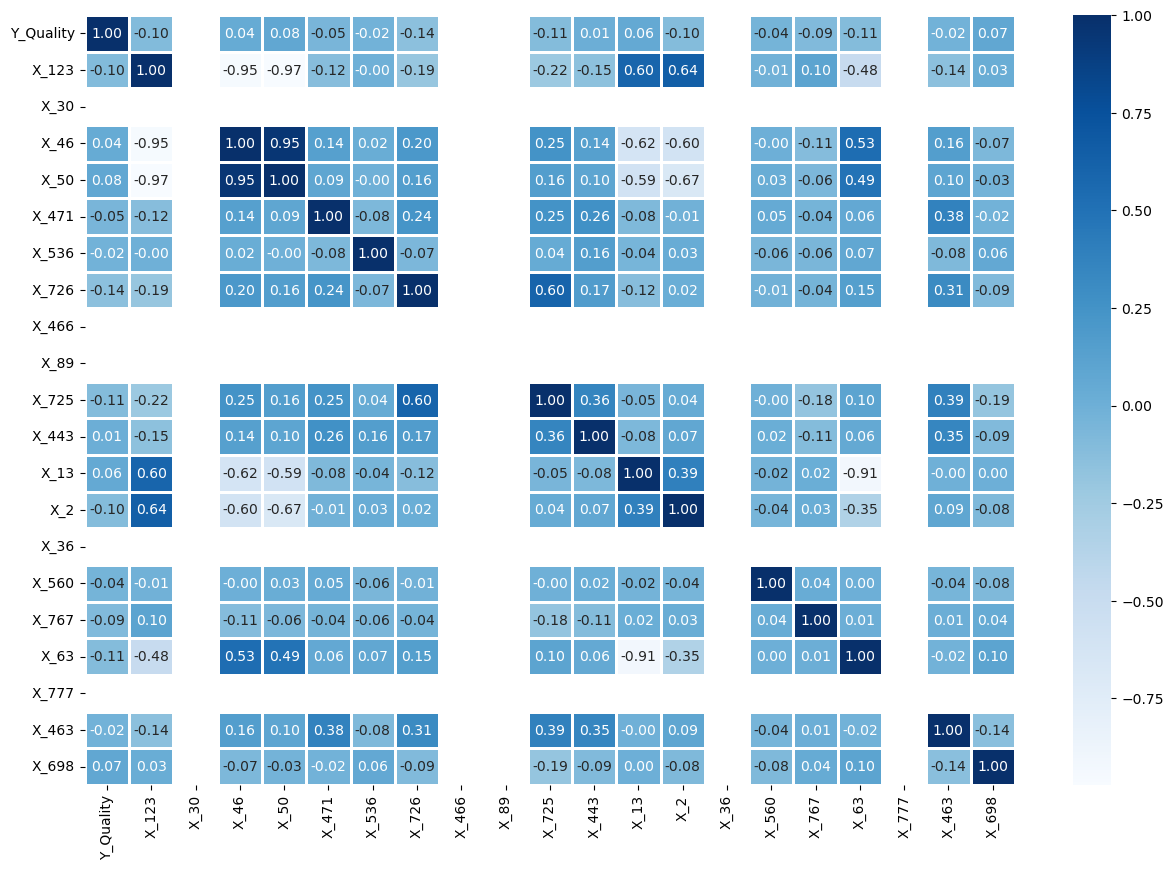

In [5]:
# random 20 features list (모두 NaN인 컬럼 제외하고, 랜덤 20개 feature의 상관관계 히트맵)
Xs = train_df.iloc[:,4:].columns
null_count = train_df.isnull().sum().to_dict()
cols = pd.DataFrame({i for i in null_count if null_count[i]<250 and i in Xs})
cols_name = list(cols[0])  # not_all_NAN features name in list 

import random
a = ['Y_Quality']
for i in range(20):
    num = random.randint(1,2875)
    a.append(cols_name[i])

# heatmap: `random X features` and `Y_Quality` correlation
corr = train_df[a].corr()  # correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', linewidths=2);

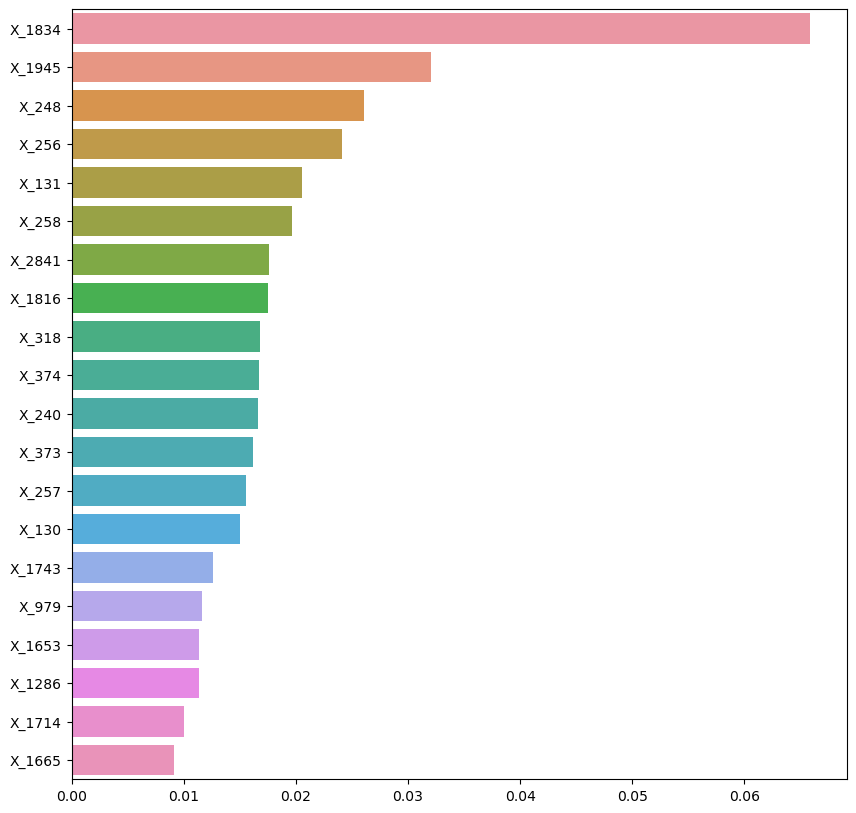

In [6]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i])

train_x = train_x.fillna(0)
test_x = test_x.fillna(0)
X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=seed_num)

%matplotlib inline
RF = RandomForestRegressor(random_state=0, max_depth=5, min_samples_leaf=8, min_samples_split=8,n_estimators=200)
RF.fit(X_train, y_train)
ftr_importances_values = RF.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(10, 10))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()      

In [8]:
# feature distribution 
train_x.describe()    

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,598.000000,598.00000,598.0,598.000000,598.000000,598.0,598.000000,598.000000,...,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.0,598.0,598.0,598.0
mean,3.214047,1.157191,1.406355,55.51505,0.0,26.262542,6.065217,0.0,28.481605,5.864548,...,8.496204,8.964498,8.295351,8.638763,11.145435,0.165552,0.0,0.0,0.0,0.0
std,1.703579,0.983298,4.655332,47.03581,0.0,22.201747,5.140970,0.0,24.308159,4.960485,...,19.189554,20.294317,18.755287,19.632753,24.961071,0.371989,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,2.000000,2.000000,91.00000,0.0,45.000000,10.000000,0.0,45.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,5.000000,2.000000,2.000000,95.00000,0.0,45.000000,10.000000,0.0,50.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,5.000000,2.000000,103.000000,102.00000,0.0,45.000000,11.000000,0.0,62.000000,11.000000,...,60.240000,68.660000,60.410000,59.930000,79.750000,1.000000,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='X_592', ylabel='Count'>

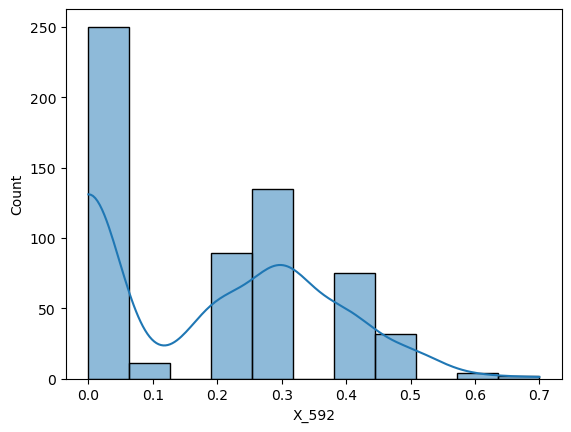

In [9]:
# feature histogram with KDE (밀도그래프) 
# 임의의 feature에 대한 histplot + 밀도 곡선 출력
num = random.randint(1,2875)
sns.histplot(train_x[f'X_{num}'], kde=True)

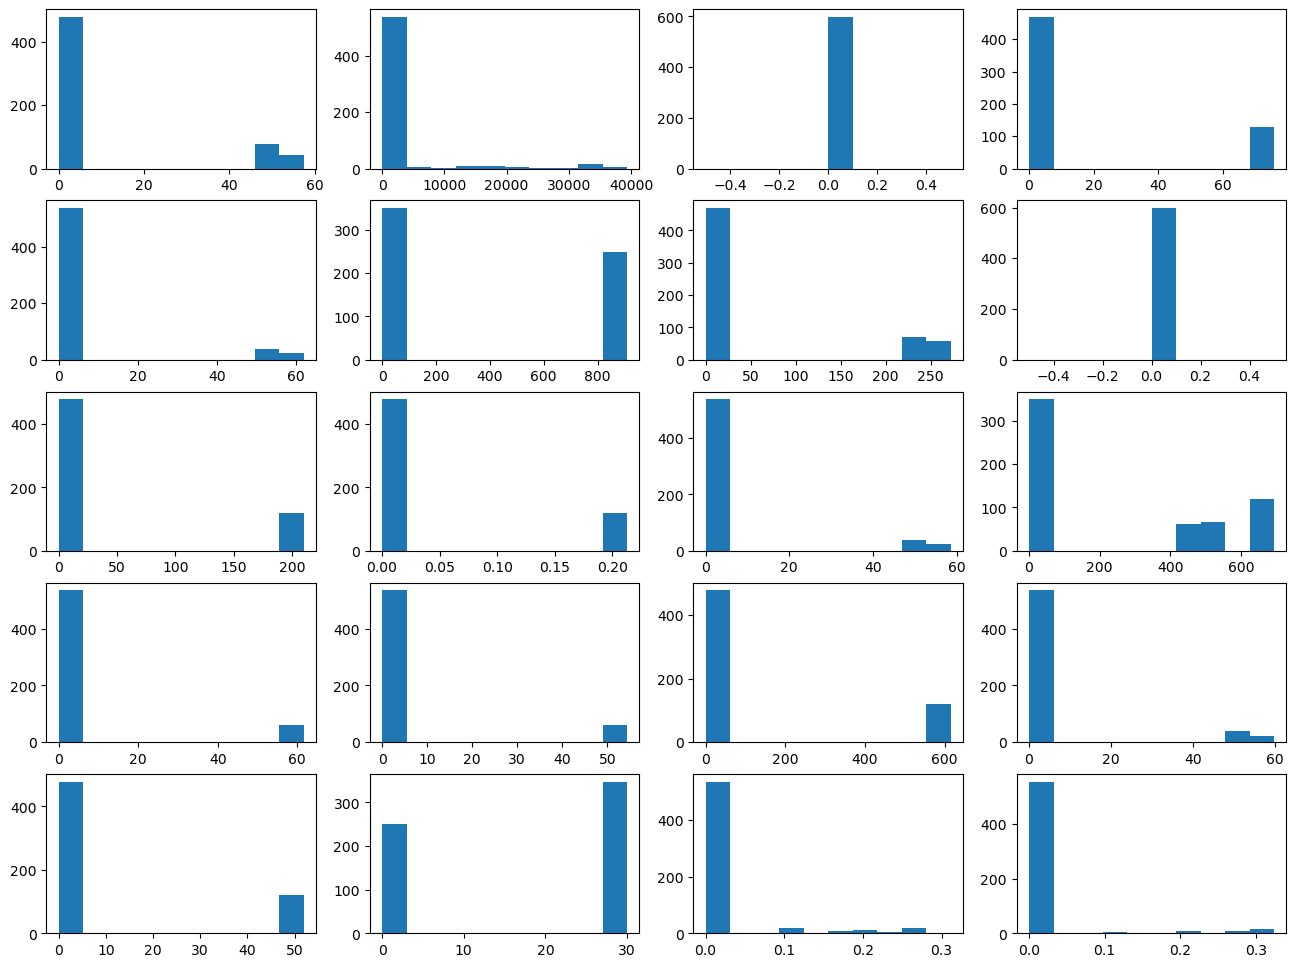

In [10]:
# visualize random 20 features distribution 
# imbalanced feature distribution (NO Gaussian distribution shape) --> MinMaxscaler
fig, axes = plt.subplots(5,4,figsize=(16,12))
ax= axes.flatten()

for i in range(20): 
    num = random.randint(1,2875)
    ax[i].hist(train_x[f'X_{num}']);    

## 1.2 Preprocessing
1. Label Encoding: categorical values `LINE`, `PRODUCT_CODE`
2. Missing values: fillna(0) 
3. scaling: StandardScaler

In [11]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
submit = pd.read_csv('./sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

In [12]:
# 1) qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()    # one-hot encoding (X): get_dummies(test_df) is not allowed (data leakage)   
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 


In [13]:
# 2) Missing Values 
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [14]:
# 3) MinMaxscaling: only `X_???` values (continuous)
Xs = train_x.select_dtypes(include=float).iloc[:,1:].columns.tolist()
scaler = MinMaxScaler().fit(train_x.loc[:, Xs])
train_x.loc[:, Xs] = scaler.transform(train_x.loc[:, Xs])
test_x.loc[:, Xs] = scaler.transform(test_x.loc[:, Xs])

X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=seed_num)

# 2.Modeling

## 2.1 ML models
- 여러 Machine Learning Classifier 모델들의 test set Accuracy score 도출 
    - Ensemble에서 각 모델의 weight(가중치) 정하기 위한 근거로 사용하기 위함
1. RandomForestClassifier
2. GradientboostingClassiifer
3. XGBClassifier
4. LGBMClassifier
5. CatboostClassifier
6. RidgeClassifier
7. BaggingClassifier

In [15]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = [
    RandomForestClassifier(random_state=seed_num), 
    GradientBoostingClassifier(random_state=seed_num),      
    XGBClassifier(random_state=seed_num),
    LGBMClassifier(objective='multiclass', random_state=seed_num),
    CatBoostClassifier(objective='MultiClass',
                                   task_type='GPU',
                                   one_hot_max_size=2, random_seed=seed_num,
                                   iterations=4000, verbose=False,
                                   learning_rate=0.05
                                   ),
    RidgeClassifierCV(),  # RidgeClassifier: no seed setting argument  
    BaggingClassifier(random_state=seed_num)]

In [16]:
# find weights for each model 
model_list = ['RF', 'GBC', 'XGB', 'LGBM', 'Catboost', 'Ridge', 'Bagging']
i=0
model_acc = {}

for model in models:  
    if i == 4: 
        preds = model.fit(X_train, y_train).predict(X_test)
        preds = preds.reshape(1,180)
        preds = list(preds[0])
    else: 
        preds = model.fit(X_train, y_train).predict(X_test)

    globals()[f'preds_{model_list[i]}'] = preds   # set variable name for each model prediction results  
  
    score = sklearn.metrics.accuracy_score(y_test, preds)
    model_acc[model_list[i]] = score
    i += 1   

print(model_acc)   

{'RF': 0.7888888888888889, 'GBC': 0.8055555555555556, 'XGB': 0.7722222222222223, 'LGBM': 0.7833333333333333, 'Catboost': 0.8222222222222222, 'Ridge': 0.7611111111111111, 'Bagging': 0.75}


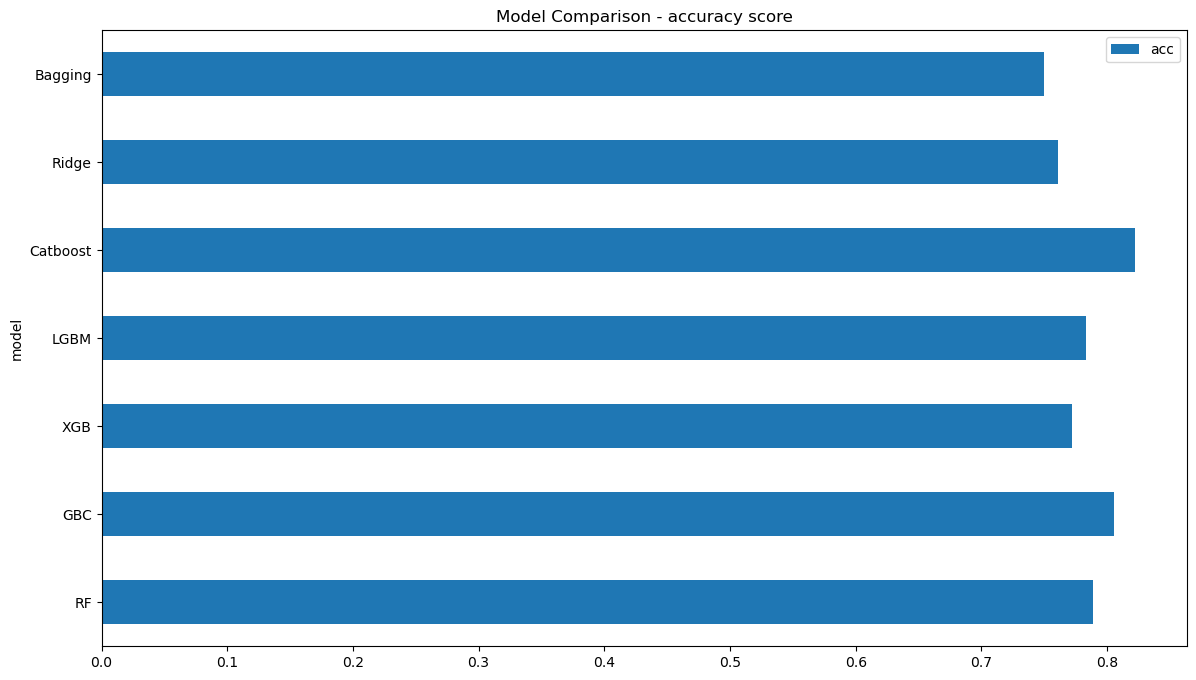

In [17]:
# ML models accuracy comparison plot 
model_name = list(model_acc.keys())
model_acc = list(model_acc.values())
acc_dic = {'model': model_name, 'acc': model_acc}
acc_df = pd.DataFrame(acc_dic)
acc_df = acc_df.set_index('model')

acc_df.plot(kind='barh', figsize=(14,8),
            title='Model Comparison - accuracy score');

## 2.2 sequential MLP 
* torch code && CUDA setting to make the same result --> TRY!!! 

In [18]:
import torch.nn as nn 
import torch.nn.functional as F 

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        """
        parameters: 
            input_dim (int): 입력 벡터 크기
            hidden_dim1 (int): 첫 번째 Linear 층의 출력 크기
            hidden_dim2 (int): 두 번째 Linear 층의 출력 크기 
            output_dim (int): 세 번째 Linear 층의 출력 크기 
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """
        MLP의 정방향 계산 

        parameters:
            x_in (torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, input_dim)
            apply_softmax (multiclasses): softmax activation function 
        return: 
            result Tensor
            tesnor.shape: (batch, output_dim)
        """
        intermediate1 = F.relu(self.fc1(x_in))   # activation function
        intermediate2 = F.relu(self.fc2(intermediate1))   # activation function
        intermediate3 = F.relu(self.fc3(intermediate2))   # activation function
        output = self.fc4(intermediate3)    


        if apply_softmax: 
            output = F.softmax(output, dim=1)   # output layer: softmax activation function
        return output 

In [19]:
def describe(x): 
    print(f'Type: {x.type()}')
    print(f'shape: {x.shape}')
    # print(f'value: {x}') 

batch_size = 256 
input_dim = train_x.shape[-1]
hidden_dim1 = 1024
hidden_dim2 = 512
hidden_dim3 = 256
output_dim = 3 

# model design 
mlp = MultilayerPerceptron(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
print(mlp)
x_input = torch.rand(batch_size, input_dim)
y_output = mlp(x_input, apply_softmax=True)  # result: probabilities format 
a = y_output
describe(y_output)

MultilayerPerceptron(
  (fc1): Linear(in_features=2877, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=3, bias=True)
)
Type: torch.FloatTensor
shape: torch.Size([256, 3])


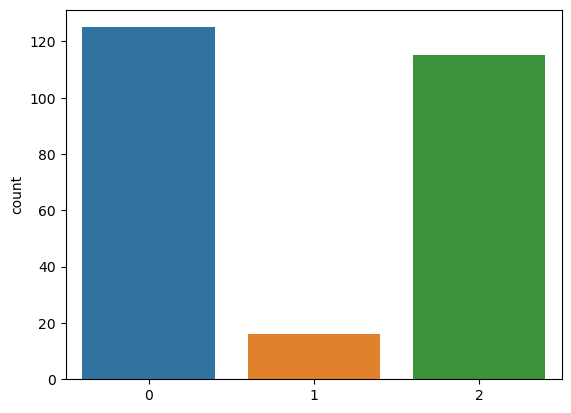

In [20]:
prediction=[]

for i in a: 
    i = list(i)
    prediction.append(i.index(max(i)))

sns.countplot(x=prediction);    

# 3.Params Optimization
1. Optuna
2. GridSearch 

## 3.1 GradientBoosting
### Optuna
- hyperparams

In [ ]:
def objective(trial, X, y, cv, scoring):
  params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step = 100),
    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log = True),
    "max_depth": trial.suggest_int("max_depth", 3, 9),
    "subsample": trial.suggest_float("subsample", 0.5, 0.9, step = 0.1),
    "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
    "random_state": 42,
    }
  # Perform cross validation
  gb_class = GradientBoostingClassifier(**params)

  # Compute scores
  scores = cross_validate(gb_class, X, y, cv = cv, scoring = scoring, n_jobs = -1)
  accuracy = scores["test_score"].mean()

  return accuracy

- Optimization for params

K-Fold, trials = 10

In [ ]:
study = optuna.create_study(direction = "maximize")

kf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=37)

func = lambda trial: objective(trial, X_train, y_train, 
                               cv = kf, scoring = "accuracy")

# %%time
# Start optimizing with 100 trials
study.optimize(func, n_trials = 10)

print(f"The highest accuracy reached by this study: {(study.best_value) * 100}%.")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")    

[I 2023-03-06 18:40:00,537] A new study created in memory with name: no-name-80942cd5-47a7-4f20-8784-9bc62f05a4a8
[I 2023-03-06 18:43:09,392] Trial 0 finished with value: 0.7130522088353414 and parameters: {'n_estimators': 3600, 'learning_rate': 0.00024680309803331603, 'max_depth': 8, 'subsample': 0.9, 'max_features': 'log2'}. Best is trial 0 with value: 0.7130522088353414.
[I 2023-03-06 18:46:04,361] Trial 1 finished with value: 0.7704819277108433 and parameters: {'n_estimators': 200, 'learning_rate': 0.1273760193808601, 'max_depth': 8, 'subsample': 0.5, 'max_features': 'auto'}. Best is trial 1 with value: 0.7704819277108433.
[I 2023-03-06 19:05:21,726] Trial 2 finished with value: 0.7800917957544463 and parameters: {'n_estimators': 1200, 'learning_rate': 0.009147154102399788, 'max_depth': 9, 'subsample': 0.8, 'max_features': 'auto'}. Best is trial 2 with value: 0.7800917957544463.
[I 2023-03-06 19:27:37,659] Trial 3 finished with value: 0.7537865748709123 and parameters: {'n_estimato

The highest accuracy reached by this study: 78.00917957544463%.
Best params:
	n_estimators: 1200
	learning_rate: 0.009147154102399788
	max_depth: 9
	subsample: 0.8
	max_features: auto


In [ ]:
import imblearn

params= {'n_estimators': 1200, 'learning_rate': 0.009147154102399788, \
        'max_depth': 9, 'subsample': 0.8, 'max_features': 'auto'}
GBC =  GradientBoostingClassifier(random_state=37, **params,                              
                                  ).fit(X_train, y_train)
preds = GBC.predict(X_test)

print(classification_report(y_test, preds))
print("\n Optuna : ", accuracy_score(y_test, preds))

c:\Users\oldbo\anaconda3\envs\mldl\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\oldbo\anaconda3\envs\mldl\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\oldbo\anaconda3\envs\mldl\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\oldbo\anaconda3\envs\mldl\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=

              precision    recall  f1-score   support

           0       0.69      0.43      0.53        21
           1       0.81      0.97      0.89       131
           2       1.00      0.39      0.56        28

    accuracy                           0.82       180
   macro avg       0.84      0.60      0.66       180
weighted avg       0.83      0.82      0.79       180


 Optuna :  0.8166666666666667


In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour
plot_param_importances(study)

### GridSearch

- hyperparameter optimization

In [ ]:
# from sklearn.model_selection import GridSearchCV

# estimator = GradientBoostingClassifier(random_state = 37)

# param_grid = {
#             'n_estimators' : [n_estimators for n_estimators in range(100, 5000, 100)],
#             'learning_rate' : [lr * 0.0001 for lr in range(1, 10)],
#             'max_depth' : [depth for depth in range(3, 9)],
#             'subsample' : [subsample * 0.1 for subsample in range(5, 9, 1)],
#             'max_features' : ['auto', 'sqrt', 'log2']
#             }

# # scoring = 'r2' -> 결정계수로 scoring
# grid_GBC = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
# grid_GBC.fit(train_x, train_y)

# print('best estimator model: \n{}'.format(grid_GBC.best_estimator_))
# print('\nbest parameter: \n{}'.format(grid_GBC.best_params_))
# print("\nbest score: \n{}".format(grid_GBC.best_score_.round(3)))

In [ ]:
# # GridSearch best parameter 
# import imblearn

# params= {'n_estimators': 1200, 'learning_rate': 0.009147154102399788, \
#         'max_depth': 9, 'subsample': 0.8, 'max_features': 'auto'}
# GBC =  GradientBoostingClassifier(random_state=37, **params,                              
#                                   ).fit(X_train, y_train)
# preds = GBC.predict(X_test)

# print(classification_report(y_test, preds))
# print("\n Grid : ", accuracy_score(y_test, preds))

## 3.2 CatBoost

In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')
     
# hyper-parameter tuning with OPTUNA  
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=37)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)  

In [ ]:
print("Number of trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ",trial.params)

model = CatBoostClassifier(**trial.params, verbose=False, random_state = 37)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Number of trials:  10
Best trial:
  Value:  0.5929126858885749
  Params:  {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, 'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', 'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, 'od_type': 'IncToDec', 'od_wait': 42}


In [ ]:
params=  {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, \
        'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', \
        'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, \
        'od_type': 'IncToDec', 'od_wait': 42}
CBC = CatBoostClassifier(**params, verbose=False, random_state=37)
CBC.fit(X_train, y_train)
preds_CBC = CBC.predict(X_test)

print(classification_report(y_test, preds_CBC))
print("\n Optuna : ", accuracy_score(y_test, preds_CBC))

              precision    recall  f1-score   support

           0       0.67      0.38      0.48        21
           1       0.80      0.97      0.88       131
           2       1.00      0.32      0.49        28

    accuracy                           0.80       180
   macro avg       0.82      0.56      0.62       180
weighted avg       0.81      0.80      0.77       180


 Optuna :  0.8


In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

In [ ]:
plot_param_importances(study)

### GridSearch

- hyperparameter optimization

In [ ]:
# from sklearn.model_selection import GridSearchCV

# estimator = CatBoostClassifier(random_state = 37)

# param_grid = {
#             'iterataions' : [iter for iter in range(100, 1000, 100)],
#             'learning_rate' : [lr * 0.0001 for lr in range(1, 10)],
#             'depth' : [depth for depth in range(4, 10)],
#             'l2_leaf_reg' : [leaf * 0.0000001 for leaf in range(1, 100, 10)],
#             'bootstrap_type' : ['Bayesian'],
#             'random_strength' : [strength * 0.1 for strength in range(1, 100, 10)],
#             'bagging_temperature' : [bag * 0.1 for bag in range(1, 10)],
#             'od_type' : ['IncToDec', 'Iter'],
#             'od_wait' : [wait for wait in range(10, 50, 4)]
#             }

# # scoring = 'r2' -> 결정계수로 scoring
# grid_CBC = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
# grid_CBC.fit(X_train, y_train)

# print('best estimator model: \n{}'.format(grid_CBC.best_estimator_))
# print('\nbest parameter: \n{}'.format(grid_CBC.best_params_))
# print("\nbest score: \n{}".format(grid_CBC.best_score_.round(3)))

In [ ]:
# params=  {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, \
#         'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', \
#         'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, \
#         'od_type': 'IncToDec', 'od_wait': 42}
# CBC = CatBoostClassifier(**params, verbose=False, random_state=37)
# CBC.fit(X_train, y_train)
# preds_CBC = CBC.predict(X_test)

# print(classification_report(y_test, preds_CBC))
# print("\n Grid : ", accuracy_score(y_test, preds_CBC))

# 4.Ensemble

## 4.1 VotingClassifier
1. Cross-Validation 구축 후 성능 비교

In [ ]:
models = [
    CatBoostClassifier(
        # objective='MultiClass', task_type='GPU', one_hot_max_size=2, iterations=4000, learning_rate=0.05, 
        verbose=False, random_seed=seed_num),
    XGBClassifier(random_state=seed_num),
    GradientBoostingClassifier(random_state=seed_num),    
]
[x.fit(train_x, train_y) for x in models]


In [ ]:
def predict(models, test, mode=None, weights=None):
    if mode == "hard":
        preds = np.asarray([x.predict(test).reshape(-1) for x in models]).T
        res = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x, weights=weights)),
            axis=1,
            arr=preds
        )
    elif mode == "soft":  
        preds = np.asarray([x.predict_proba(test) for x in models])
        res = np.zeros(preds[0].shape)
        for pred, weight in zip(preds, weights):
            res = res + pred*weight
        res = np.argmax(preds, axis=0) 
    else:
        res = models[0].predict(test)
    return res

preds = predict(models, test_x, 'hard',  
                [2,1,2] )

sns.countplot(x=preds);    
preds

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

submit['Y_Class'] = preds
submit.to_csv('CXG212(1)-smartFactorySubmission.csv', index=False)  
sns.countplot(x=preds);
submit.Y_Class.value_counts()

## 4.2 StackingClassifier

In [ ]:
stack = StackingClassifier(
    estimators=models,
    final_estimator=LogisticRegression(),  
    cv=5,
    n_jobs=4,
    passthrough=True
)

# use X_test as validation set      
stack.fit(train_x, train_y)

train_stack = np.concatenate(
    [model.predict_proba(train_x) for model in models], axis=1)
val_stack = np.concatenate(
    [model.predict_proba(X_test) for model in models], axis=1)

# meta model training
meta_model = LogisticRegression().fit(train_stack, train_y)
preds = meta_model.predict(val_stack)



In [ ]:
seed_num=37

GBC_model = GradientBoostingClassifier(random_state=37
              ).fit(train_x, train_y)

preds = GBC_model.predict(test_x)
sns.countplot(x=preds);

# 5.Submit

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('smartFactorySubmission.csv', index=False)

# 6.References

1. EDA & Preprocessing
    * 
    * 
2. Modeling 
    * 
    * 
3. Params Optimization
    * 
    *
4. Ensemble 
    * 
    * 
